In [33]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
# !pip install pyarrow

In [3]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df["tpep_dropoff_datetime"]-df["tpep_pickup_datetime"]
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # only use rides which were between 1 to 60 minutes
    df = df[(df.duration>=1) & (df.duration<=60)]
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
train_df = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet")
val_df = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet")

In [9]:
train_df.duration.min(),train_df.duration.max()

(1.0, 60.0)

In [10]:
len(train_df),len(val_df)

(2898906, 2898906)

In [12]:
# len(df)

In [21]:
train_df["PU_DO"] = train_df["PULocationID"] + "_" + train_df["DOLocationID"]
val_df["PU_DO"] = val_df["PULocationID"] + "_" + val_df["DOLocationID"]

In [24]:
train_df["PU_DO"].head()

0     186_79
1    140_236
2     236_79
3     79_211
4    211_148
Name: PU_DO, dtype: object

In [25]:
# categorical = ["PULocationID", "DOLocationID"]
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = train_df[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

train_dicts = val_df[categorical + numerical].to_dict(orient="records")
X_val = dv.fit_transform(train_dicts)

In [26]:
target = "duration"
y_train = train_df[target].values
y_val = val_df[target].values

In [27]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.185322634109333

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


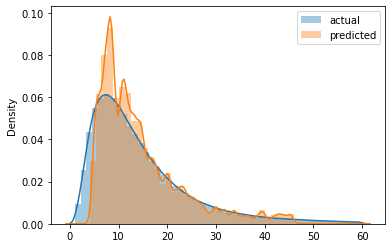

In [28]:
sns.distplot(y_val,label="actual")
sns.distplot(y_pred,label="predicted")
plt.legend()

In [35]:
with open("models/lin_reg.bin","wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [30]:
lasso = Lasso()
lasso.fit(X_train,y_train)

y_pred = lasso.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.158477691740408

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


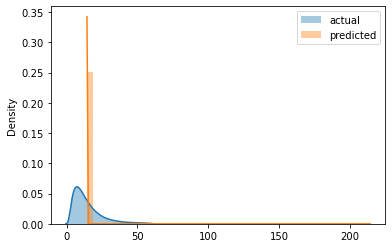

In [31]:
sns.distplot(y_val,label="actual")
sns.distplot(y_pred,label="predicted")
plt.legend()

In [40]:
# reading the pickled objects
pickle.load(open("models/lin_reg.bin","rb"))

(DictVectorizer(), LinearRegression())